0 0~6
1 6~12
2 12~18
3 18~24

시간대, 분, 수유량
0, 100, 50
1, 200, 30
2, 100, 30

In [54]:
param_window_size = 6
param_seq_length = 287
param_num_epoch = 10
param_lstm_units = 64
param_lstm_stack = 2

num_sample = param_seq_length - param_window_size

In [55]:
import numpy as np
import os
import pandas
import theano

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

In [56]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back)])
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def diff_dataset(dataset):
    diff = np.zeros((dataset.shape[0]-1, 1))
    for i in range(dataset.shape[0]-1):
        diff[i] = dataset[i,0]-dataset[i+1,0]
    return diff

def reverse_diff_dataset(diff, init_value):
    reverse = np.zeros((diff.shape[0]+1, 1))
    reverse[0] = init_value
    for i in range(diff.shape[0]):
        reverse[i+1] = reverse[i] - diff[i]    
    return reverse

In [57]:
dataset_file_path = './warehouse/feeding.csv'
df = pandas.read_csv(dataset_file_path, header=None)

In [58]:
ds_org = df.values
ds_org = ds_org.astype('float32')

dataset = ds_org

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, param_window_size)
testX, testY = create_dataset(test, param_window_size)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

In [60]:
test_size

16

In [62]:
%%time

theano.config.compute_test_value = "ignore"

model = Sequential()
for i in range(param_lstm_stack):
    model.add(LSTM(param_lstm_units, batch_input_shape=(1, param_window_size, 2), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(param_lstm_units, batch_input_shape=(1, param_window_size, 2), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam')

CPU times: user 938 ms, sys: 33.5 ms, total: 972 ms
Wall time: 965 ms


In [63]:
for epoch_idx in range(param_num_epoch):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
0s - loss: 0.1592
epochs : 1
Epoch 1/1
0s - loss: 0.0449
epochs : 2
Epoch 1/1
0s - loss: 0.0338
epochs : 3
Epoch 1/1
0s - loss: 0.0265
epochs : 4
Epoch 1/1
0s - loss: 0.0222
epochs : 5
Epoch 1/1
0s - loss: 0.0207
epochs : 6
Epoch 1/1
0s - loss: 0.0178
epochs : 7
Epoch 1/1
0s - loss: 0.0196
epochs : 8
Epoch 1/1
0s - loss: 0.0163
epochs : 9
Epoch 1/1
0s - loss: 0.0189


In [64]:
testScore = model.evaluate(testX, testY, batch_size=1, verbose=0)
print('Test Score: ', testScore)

model.reset_states()

('Test Score: ', 0.0080457720672711727)


In [69]:
predictions = np.zeros((look_ahead,2))
predictions

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [70]:
look_ahead = test_size
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,2))

for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=1)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

In [71]:
predictions

array([[ 0.95775187, -0.06730338],
       [ 0.96825385, -0.06781343],
       [ 0.96756935, -0.06808294],
       [ 0.96363163, -0.06806617],
       [ 0.95933211, -0.06791537],
       [ 0.9551028 , -0.06772245],
       [ 0.95101666, -0.06751484],
       [ 0.94950151, -0.06736867],
       [ 0.94860983, -0.06727738],
       [ 0.9477663 , -0.06721059],
       [ 0.94703758, -0.06715523],
       [ 0.94647312, -0.06711019],
       [ 0.94607353, -0.06707608],
       [ 0.94582582, -0.06705294],
       [ 0.94565439, -0.06703744],
       [ 0.94552088, -0.06702615]])

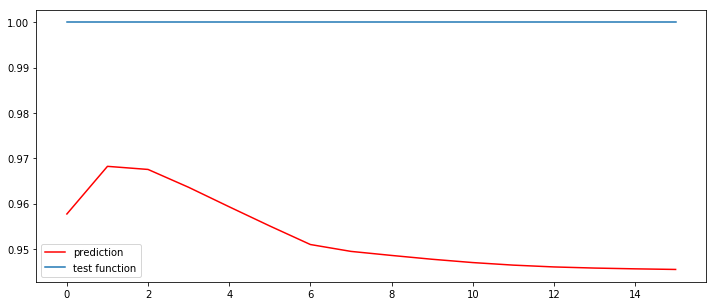

In [72]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions[:,0],'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead),0],label="test function")
plt.legend()
plt.show()

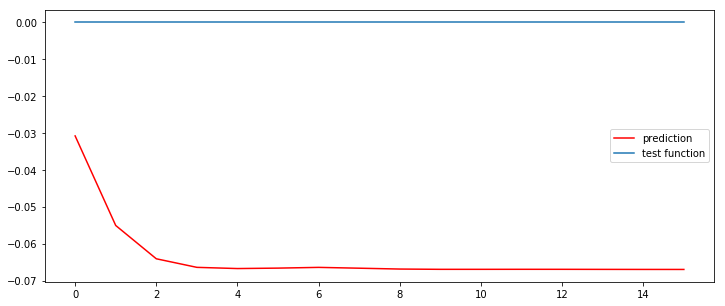

In [68]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions[:,1],'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead),1],label="test function")
plt.legend()
plt.show()